In [90]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

def dateparse(time):
    return datetime.datetime.fromtimestamp(float(time)/1000)

data_new = pd.read_csv('/home/maksym/2021-1h-BTCUSDT_part_2.csv', parse_dates=['Start', 'Stop'], date_parser=dateparse)
data_old = pd.read_csv('/home/maksym/2021-knu-market/data/[1h]BTCUSDT.csv', parse_dates=['Start', 'Stop'], date_parser=dateparse)



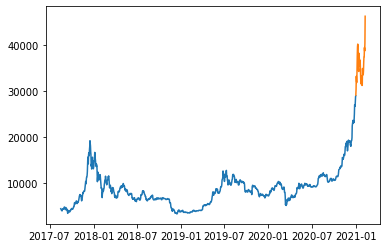

In [91]:

dataOpen = data_old[['Start','Open']]
dataOpen = dataOpen.set_index('Start')
dataOpen = dataOpen.resample('24H').mean() #Train open mean price per day
date_old = dataOpen.index #list of dates
range_ = pd.RangeIndex(0, len(dataOpen)) 
dataOpen_old = dataOpen.set_index(range_) 

dataOpen = data_new[['Start','Open']]
dataOpen = dataOpen.set_index('Start')
dataOpen = dataOpen.resample('24H').mean() #Test open mean price per day
date_new = dataOpen.index #list of dates
range_ = pd.RangeIndex(0, len(dataOpen)) 

dataOpen_new = dataOpen.set_index(range_) 




plt.plot(date_old, dataOpen_old) #non-stationary
plt.plot(date_new, dataOpen_new) #non-stationary

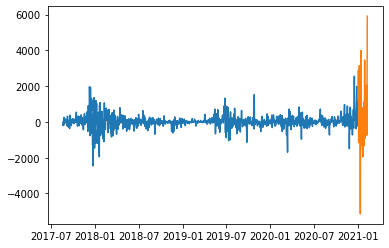

In [52]:
dataOpen_stat_old = dataOpen_old.diff(periods=1).dropna() #stationary
dataOpen_stat_new = dataOpen_new.diff(periods=1).dropna() #stationary
plt.plot(date_old[1:], dataOpen_stat_old)
plt.plot(date_new[1:], dataOpen_stat_new)

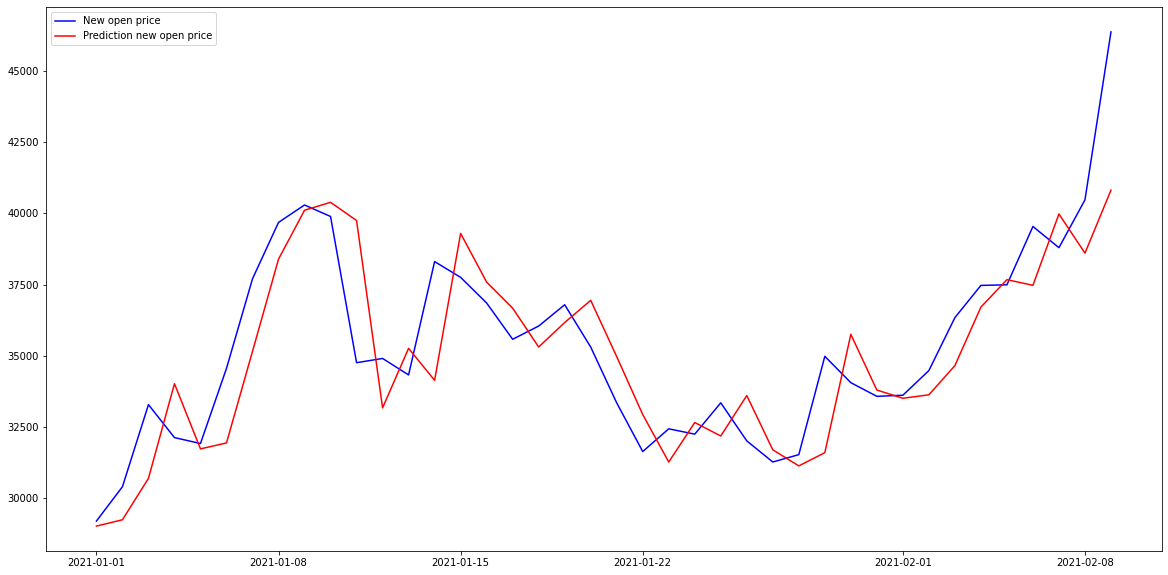

In [81]:
#ARIMA

train, test = dataOpen_old.Open.tolist(), dataOpen_new.Open.tolist()
predict_arima = []

for i in range(len(test)):
    
    m = ARIMA(train, order=(1,1,1)).fit()
    p = m.forecast()[0]
    
    train.append(test[i])
    predict_arima.append(p)

plt.figure(figsize=(20,10))

plt.plot(date_new, test, 'b',label='New open price')
plt.plot(date_new, predict_arima, 'r',label='Prediction new open price')
plt.legend()


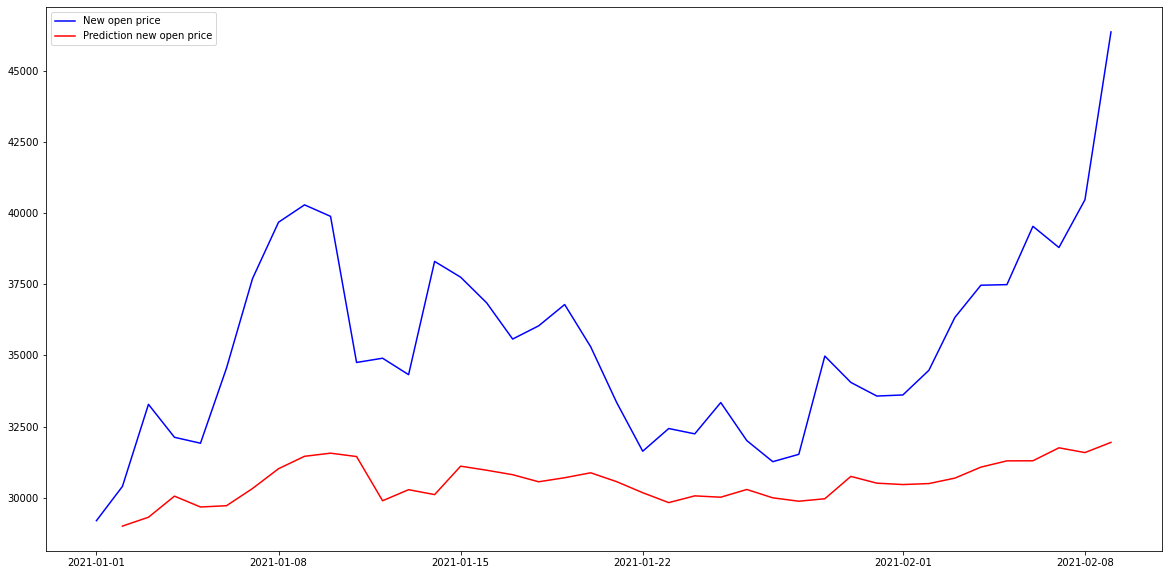

In [82]:
#ARMA


#train and test stationary series
train, test = dataOpen_stat_old.Open.tolist(), dataOpen_stat_new.Open.tolist()
predict_arma = []
for i in range(len(test)):
    
    m = ARIMA(train, order=(1,0,1)).fit()
    p = m.forecast()[0]
    
    train.append(test[i])
    predict_arma.append(p)

#predict non-stationary series
predict_arma_renewed = np.zeros(len(predict_arma))
predict_arma_renewed [0] = dataOpen_old[-1:].values

for i in range(1,len(predict_arma)):
    predict_arma_renewed[i] = predict_arma[i] +  predict_arma_renewed[i-1]
plt.figure(figsize=(20,10))

plt.plot(date_new,dataOpen_new, 'b', label='New open price')
plt.plot(date_new[1:],predict_arma_renewed, 'r', label='Prediction new open price')
plt.legend()



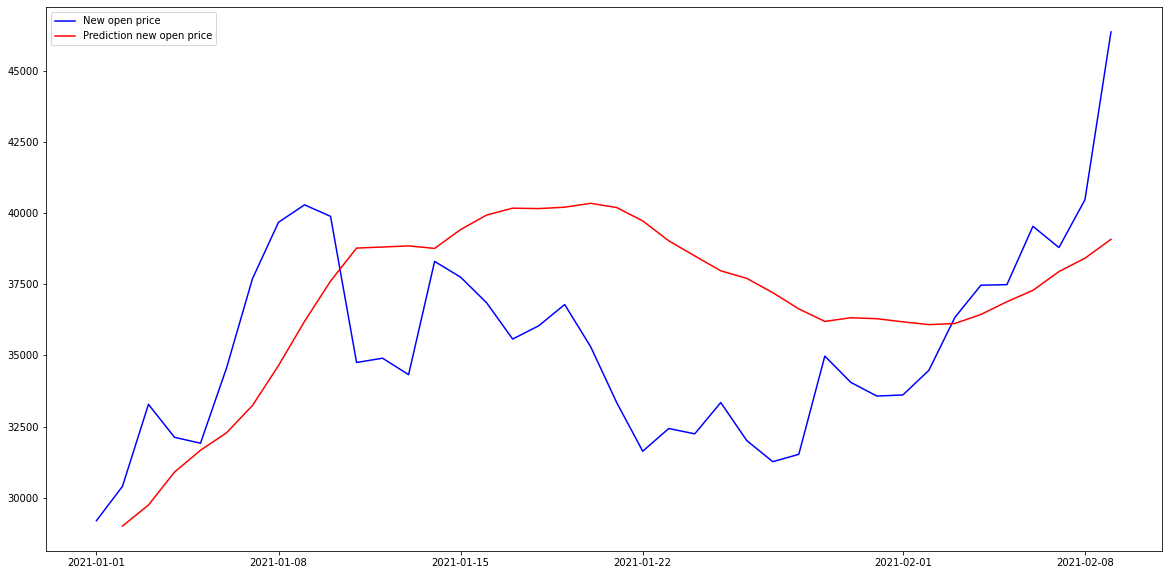

In [83]:
#HWES
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#train and test stationary series


train, test = dataOpen_stat_old.Open.tolist(), dataOpen_stat_new.Open.tolist()
predict_hwes = []

for i in range(len(test)):
    
    m = ExponentialSmoothing(train, trend = 'add').fit()
    p = m.forecast()[0]
    
    train.append(test[i])
    predict_hwes.append(p)

#predict non-stationary series
predict_hwes_renewed  = np.zeros(len(predict_hwes))
predict_hwes_renewed[0] = dataOpen_old[-1:].values

for i in range(1,len(predict_hwes)):
    predict_hwes_renewed[i] = predict_hwes[i] +  predict_hwes_renewed[i-1]

plt.figure(figsize=(20,10))
plt.plot(date_new,dataOpen_new, 'b', label='New open price')
plt.plot(date_new[1:],predict_hwes_renewed, 'r', label= 'Prediction new open price')

plt.legend()

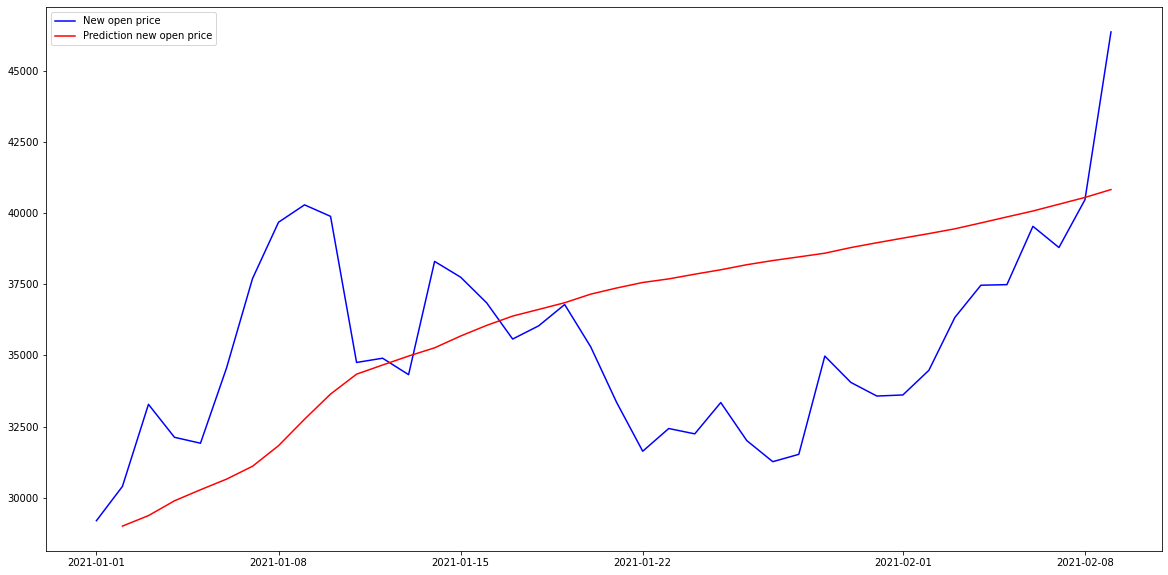

In [84]:
#SES
from statsmodels.tsa.api import SimpleExpSmoothing



train, test = dataOpen_stat_old.Open.tolist(), dataOpen_stat_new.Open.tolist()
predict_ses = []

for i in range(len(test)):
    
    m = SimpleExpSmoothing(train).fit()
    p = m.forecast()[0]
    
    train.append(test[i])
    predict_ses.append(p)

#predict non-stationary series
predict_ses_renewed = np.zeros(len(predict_ses))
predict_ses_renewed [0] = dataOpen_old[-1:].values

for i in range(1,len(predict_ses)):
    predict_ses_renewed [i] = predict_ses[i] +  predict_ses_renewed [i-1]

plt.figure(figsize=(20,10))
plt.plot(date_new,dataOpen_new, 'b',label='New open price')
plt.plot(date_new[1:],predict_ses_renewed, 'r',label='Prediction new open price')
plt.legend()

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
print('ARMA mean absolute error : ', mean_absolute_error(dataOpen_new[:-1], predict_arma_renewed))
print('ARIMA mean absolute error : ',  mean_absolute_error(dataOpen_new, predict_arima))
print('SES mean absolute error : ',  mean_absolute_error(dataOpen_new[1:], predict_ses_renewed))
print('HWES mean absolute error : ',  mean_absolute_error(dataOpen_new[1:], predict_hwes_renewed))

print('ARMA mean squared error : ', sqrt(mean_squared_error(dataOpen_new[:-1], predict_arma_renewed)))
print('ARIMA mean squared error : ',  sqrt(mean_squared_error(dataOpen_new, predict_arima)))
print('SES mean squared error : ',  sqrt(mean_squared_error(dataOpen_new[1:], predict_ses_renewed)))
print('HWES mean squared error : ',  sqrt(mean_squared_error(dataOpen_new[1:], predict_hwes_renewed)))


ARMA mean absolute error :  4535.557720842646
ARIMA mean absolute error :  1476.5461363924571
SES mean absolute error :  3514.4946733316106
HWES mean absolute error :  3420.440582596861
ARMA mean squared error :  5077.765930456343
ARIMA mean squared error :  1936.429914617223
SES mean squared error :  4242.473309337359
HWES mean squared error :  4012.1583072541302


ARIMA best predicted new bitcoin prices. It can be seen in the graphs and MAE, RMSE  values